## TD(0) for Estimation Algorithm

- TD $\; \rightarrow \;$ Temporal Difference

In [ ]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from blackjack.plot_utils import plot_policy, plot_win_rate

# create Blackjack environment
env = gym.make("Blackjack-v1", natural=False, sab=False)

In [ ]:
def epsilon_soft_strategy(env, Q, state, epsilon):
    probs = np.zeros(2)
    # since there are only two actions: 0 and 1
    # so, optimal action is either 0 or 1
    # and, sub-optimal action is the other one 
    optimal_action = np.argmax(Q[state])
    sub_optimal_action = np.abs(optimal_action - 1)
    probs[optimal_action] = 1 - epsilon + epsilon/env.action_space.n
    probs[sub_optimal_action] = epsilon/env.action_space.n
    action = np.random.choice([0,1], p=probs)
    return action


In [ ]:
def epsilon_greedy_strategy(env, epsilon, policy, state):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(policy[state])
    

In [ ]:
class TD0_Estimation:
    def __init__(self, env, num_episodes, epsilon, target_strategy, 
                 target_policy, behavior_strategy, behavior_policy, 
                 gamma=1, epsilon_min=None, decay_rate=None, alpha=None):
        """
        param env: (gymnasium environment) the environment to run the algorithm on
        param num_episodes: (int) number of episodes to run the algorithm
        param epsilon: (float) 
        param epsilon_min: float or None
        param decay_rate: float or None
        param gamma: (float) discount factor
        param alpha: float or None
        """
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.decay_rate = decay_rate
        self.gamma = gamma
        n_actions = self.env.action_space.n
        self.Q = defaultdict(lambda: np.zeros(n_actions))  # state-action value
        self.N = defaultdict(lambda: np.zeros(n_actions))  # visit count
        self.target_policy = target_policy
        self.behavior_policy = behavior_policy
        self.target_strategy = target_strategy
        self.behavior_strategy = behavior_strategy
        self.gamma = gamma                      # discount factor
        self.epsilon = epsilon                  # exploration rate
        self.alpha = alpha                      # constant factor
        self.rewards_all_episodes_fv = []
        self.rewards_all_episodes_ev = []
    

    def generate_episode(self):
        state, _ = self.env.reset()
        episode = []
        while True:
            action = self.behavior_strategy(self.env, self.epsilon, 
                                            self.behavior_policy, 
                                            state)
            next_state, reward, done, trunc, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if (done or trunc):
                break
        return episode


    def first_visit(self):
        """
        This is the first-visit Off-Policy MC control algorithm.
        """
        for k in tqdm(range(1, self.num_episodes+1)):
            experience = self.generate_episode()
            states, actions, rewards = zip(*experience)
            self.rewards_all_episodes_fv.append(sum(rewards))
            G = 0
            W = 1
            for t in range(len(states)-1, -1, -1):
                s, a, r = states[t], actions[t], rewards[t]
                G = self.gamma * W * G + r
                if s not in states[:t]:
                    if self.alpha is not None:
                        self.Q[s][a] = self.Q[s][a] + self.alpha * (G - self.Q[s][a])
                    else:
                        self.N[s][a] += 1
                        self.Q[s][a] = self.Q[s][a] + (1 / self.N[s][a]) * (G - self.Q[s][a])
                    # update the policy
                    for state_value, q_value in self.Q.items():
                        self.target_policy[state_value] = q_value
                    W = W * self.target_policy[s][a] / self.behavior_policy[s][a]
            # update epsilon
            if (self.decay_rate is not None) and (self.epsilon_min is not None):
                self.epsilon = max(self.epsilon_min, self.epsilon * self.decay_rate)
            else:
                self.epsilon = 1/k
                

In [ ]:
env = gym.make("Blackjack-v1", natural=False, sab=False)
n_actions = env.action_space.n
random_policy = defaultdict(lambda: np.ones(n_actions) / n_actions)
num_episodes = 10_000
gamma = 1
epsilon = 1
strategy = epsilon_greedy_strategy

In [ ]:
fv_offpol = Off_Policy_MC_Control(env, num_episodes, epsilon, strategy, random_policy,
                                strategy, random_policy)

In [ ]:
fv_offpol.generate_episode()

[((14, 7, 0), 0, -1.0)]

In [ ]:
fv_offpol.first_visit()

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_34131/2801127061.py:71: RuntimeWarning: invalid value encountered in double_scalars
  W = W * self.target_policy[s][a] / self.behavior_policy[s][a]
100%|██████████| 10000/10000 [00:02<00:00, 4293.68it/s]


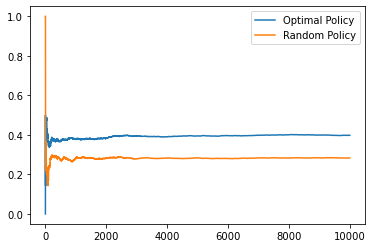

In [ ]:
plot_win_rate(fv_offpol.rewards_all_episodes_fv, fv_offpol.num_episodes)

/home/aryaman/Desktop/Pet-Projects/model-implementations/reinforcement-learning/model-free/blackjack/plot_utils.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])


TypeError: Image data of dtype object cannot be converted to float

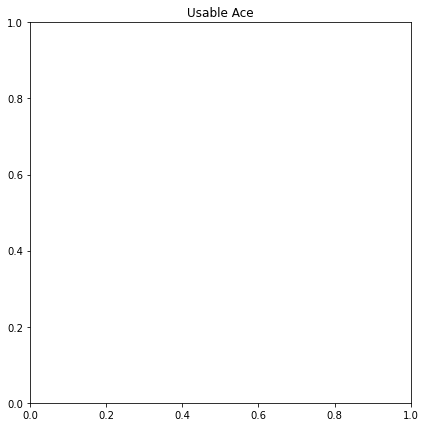

In [ ]:
# the plots are empty as we don't have a policy, ie,
# we are following a random policy
plot_policy(fv_offpol.target_policy)